<a href="https://colab.research.google.com/github/nicolez9911/colab/blob/main/AdvML_L3S1_N2_Interpretable_Dimensions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 07_EX_02 Interpretability II


The focus of this notebook is the concept of interpretability.

Specifically we want to demonstrate the importance of interpretability on the feature dimension level.
In the lecture we have explored the example of the non-meaningful dimensions of a word2vec vector.
In the prior notebook we looked at using Heatmaps and plots of the values as instruments for our understanding.

In this notebook we try to further increase the interpretability of the dimensions of our weight vector.


# Training Material

### MNIST Dataset

In order to start testing our Perceptron implementation we will move to a different and more realistially sized MNIST dataset.

We have already used the MNNIST dataset in the last semester when we started to familiarize us with the Machine Learning workflow.

"MNIST database of handwritten digits, available from this page, has a training set of 60,000 examples, and a test set of 10,000 examples. It is a subset of a larger set available from NIST. The digits have been size-normalized and centered in a fixed-size image." (source: http://yann.lecun.com/exdb/mnist/)

To save you some time the following cell contains code to download and sort the dataset.

In [ ]:
# Download and sort the dataset

# Sorts the dataset by target (i.e the numbers 0-9). Sorts only the first 60000 entries (the training set).
def sort_by_target(mnist):
    reorder_train = np.array(sorted([(target, i) for i, target in enumerate(mnist.target[:60000])]))[:, 1]
    reorder_test = np.array(sorted([(target, i) for i, target in enumerate(mnist.target[60000:])]))[:, 1]
    mnist.data[:60000] = mnist.data[reorder_train]
    mnist.target[:60000] = mnist.target[reorder_train]
    mnist.data[60000:] = mnist.data[reorder_test + 60000]
    mnist.target[60000:] = mnist.target[reorder_test + 60000]


# Download and sort the dataset
try:
    from sklearn.datasets import fetch_openml
    mnist = fetch_openml('mnist_784', version=1, cache=True)
    mnist.target = mnist.target.astype(np.int8) # fetch_openml() returns targets as strings
    sort_by_target(mnist) # fetch_openml() returns an unsorted dataset
except ImportError:
    from sklearn.datasets import fetch_mldata
    mnist = fetch_mldata('MNIST original')
mnist["data"], mnist["target"]


print(mnist.target.shape)
print(mnist.data.shape)


(70000,)
(70000, 784)


## Creating a Binary Training Set


**Note**: Since the implementation of our Perceptron is binary it only will correctly work if we use the target values `-1` and `1`. That means you have to map `0` and `9` to `-1` and `1` in the training data.

In [ ]:
from sklearn.utils import shuffle


# Select 5000 values for 0 and 9 each by manually checking the boundaries or by checking for target value.
mnist_0_target = mnist.target[0:5000]
mnist_0_data = mnist.data[0:5000]
mnist_9_target = mnist.target[6000:11000]
mnist_9_data = mnist.data[6000:11000]
mnist_bin_0_9_data = np.concatenate((mnist_0_data, mnist_9_data))
mnist_bin_0_9_target = np.concatenate((mnist_0_target, mnist_9_target))
mnist_bin_0_9_target = np.where(mnist_bin_0_9_target == 0, -1, 1)

# Shuffle should be something that the students have to identify as an element that impacts the learning
X, y = shuffle(mnist_bin_0_9_data, mnist_bin_0_9_target)
X = mnist_bin_0_9_data
y = mnist_bin_0_9_target
len(mnist_bin_0_9_data)

10000

## 1. Perceptron class

We will re-use the Perceptron class from `04_EX_01`.

The class is capable of doing binary classification and provides of the following methods:

* fit: train the Perceptron
* net_input: calculate the net_input
* predict: make a prediction based on a sample input

We have done one major change in this class compared to the version you have utilized so far.
Instead of calculating the dot product manually in Python we have delegated that to the `numpy.dot` method.


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os


import numpy.random
from matplotlib._cm_listed import cmaps

class Perceptron(object):

    """Perceptron binary classifier.

    Parameters
    -----------
    eta : float
       Learning rate (value between 0.0 and 1.0)
    epochs  : int
       Number of passes over the training set

    Attributes
    -----------
    w_  : 1d-array
       Weights after fitting.
    errors_   : list
       Number of updates (triggered by prediction != target)

    """

    def __init__(self, eta=0.01, epochs=10, random_state=1):
        self.eta = eta
        self.epochs = epochs
        self.random_state = random_state
        # this initialize the weights
        rgen = numpy.random.RandomState(self.random_state)
        self.w_ = rgen.normal(loc=0.0, scale=0.01, size=1 + X.shape[1])



    def fit(self, X, y, draw, heatmap):
        """ Fit training data; i.e. train the Perceptron

        Parameters
        -----------
        X : dataframe with shape - [n_samples, n_features]
          feature vectors, where n_samples is the number of samples
          in the data set, n_features is the number of features
        y : dataframe with shape = [n_samples].
            1 target value per sample (the label).

        Returns
        -----------
        self : object

        """


        # this will be used to store the number of updates per epoch
        self.errors_ = []

        for _ in range(self.epochs):
            errors = 0
            for xi, target in zip(X, y):
                error = target - self.predict(xi)
                if (error != 0):
                    update = self.eta * (error)
                    self.w_[1:] += update * xi
                    self.w_[0] += update
                    errors += int(update != 0.0)
            self.errors_.append(errors)
        return self

    def net_input(self, x):
        """Calculate net input"""
        net_input = np.dot(x, self.w_[1:]) + self.w_[0]
        return net_input

    def predict(self, x):
        """Predict based on computing the net input and the threshold function"""
        net_input = self.net_input(x)
        if net_input >= 0.0:
            prediction = 1
        elif net_input < 0.0:
            prediction = -1
        return prediction

# Visualizing the semantics of the dimensions.

The next cell contains an implementation that allows us
to visualize the dimensions of the weight vector learnt by the
Perceptron based on projecting back into the 2D space.

In [ ]:
import numpy as np
from IPython.display import clear_output
from time import sleep
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as col
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import cm


mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)


N=256
zero_pt0 = 0.5
zero_pt_rounded = np.ceil(zero_pt0*(N-1))/float(N-1)

cmap = plt.get_cmap("RdBu")
cmap.set_bad(color='white')

def draw_weight_vector(weight_vector, redraw):
    transf_weight_vector = np.copy(weight_vector[1:])
    transf_weight_vector = np.ma.masked_where(transf_weight_vector < 0.035, transf_weight_vector)
    #transf_weight_vector[np.abs(transf_weight_vector) < 1] = 0.5
    some_digit_image =  transf_weight_vector.reshape(28, 28)
    plt.imshow(some_digit_image, cmap, interpolation="nearest")
    plt.axis("off")
    plt.show()
    sleep(0.1)
    if redraw:
        clear_output(wait=True)





# Exercise 1: Visualize The Random Weight Vector

Use the `draw_weight_vector` method to visualize the weight vector of the Perceptron directly after initialisation of the class.

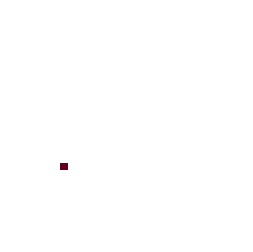

In [ ]:
# your output might look similar to what is shown below



## Exercise 2: Integrate into the Training Process

Integrate the visualisation into the training process.
We now have the ability to map and draw the weights in relation to the original place of the pixels.

1. Integrate the draw_weight_vector functionality into the Pereceptron#fit class
2. Train the percpetron class

Your output should look similar to what is shown below.
The plot of the weights in 2D should be re-drawn with every update that is made.

Training Finished


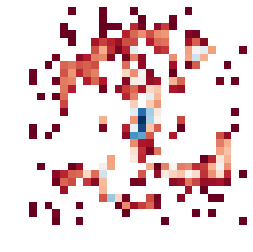

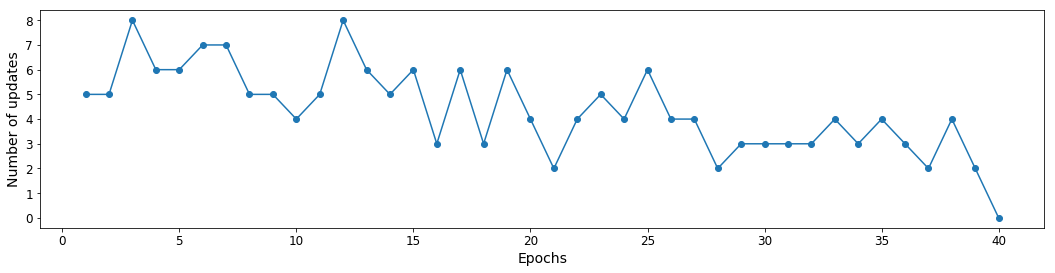

In [ ]:
ppn = Perceptron(eta=0.02, epochs=7)


print('Training Finished')

# Plot number of epochs versus number of updates (i.e. errors, false classifications).
plt.plot(range(1, len(ppn.errors_) + 1), ppn.errors_, marker='o')
plt.xlabel('Epochs')
plt.ylabel('Number of updates')
plt.show()

